# ***<u>The Future of Basketball Players</u>***

# Set up Environment

In [1]:
# The usuals
import os
import sys
import subprocess
import pandas as pd
import numpy as np

# Useful stuff
from zipfile import ZipFile
from joblib import dump, load
from pprint import pprint
from pandas_profiling import ProfileReport
from IPython.display import IFrame
import random
from statistics import mode
from datetime import datetime
from scipy.stats import uniform, randint

# SkLearn bits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# PyTorch bits
import torch
from torch import nn
from torch.nn import functional as F

# Autoreload
%load_ext autoreload
%autoreload

In [2]:
# Ensure the directory is correct... every time.
for i in range(5):
    if not os.getcwd().lower() == subprocess.run("git rev-parse --show-toplevel", stdout=subprocess.PIPE).stdout.decode("utf-8").replace("/","\\").strip().lower():
        os.chdir(".."),
    else:
        break

In [3]:
# Set up sys path environment
if not os.path.abspath(".") in sys.path:
    sys.path.append(os.path.abspath("."))
else:
    sys.path.remove(os.path.abspath("."))
    sys.path.append(os.path.abspath("."))

## Custom Globals

In [4]:
# Import customs
from src.utils.misc import get_list_proportions
from src.utils.performance import TicToc
from src.models.performance import save_reg_perf
from src.models.train_model import easy_random_search

In [5]:
# Instantiate Global Classes
t = TicToc()

## Get Data

In [6]:
# Check & Create directories
for dir in ["./data/processed/Chris", "./models/Chris"]:
    if not os.path.exists(dir): os.mkdir(dir)

In [7]:
# Use bash to get data from kaggle
!kaggle competitions files -c uts-advdsi-nba-career-prediction
!kaggle competitions download -c uts-advdsi-nba-career-prediction --path ./data/raw --force --quiet

# Unzip the data
with ZipFile("./data/raw/uts-advdsi-nba-career-prediction.zip", "r") as z:
    z.extractall("./data/raw")

# Delete the zip file
if os.path.exists("./data/raw/uts-advdsi-nba-career-prediction.zip"):
    os.remove("./data/raw/uts-advdsi-nba-career-prediction.zip")

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv   40KB  2021-01-30 23:13:35  
test.csv               323KB  2021-01-30 23:13:35  
train.csv              701KB  2021-01-30 23:13:35  


In [8]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
data = pd.read_csv("./data/raw/train.csv")

# Check data
# print(data.columns)
display(data)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [9]:
# Fix column names
print(data.columns)
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Save training data again
data.to_csv("./data/raw/train.csv", index=False)

# Apply same logix to test data
test = pd.read_csv("./data/raw/test.csv")
test.columns = test.columns.str.replace(' ', '_')
test.to_csv("./data/raw/test.csv", index=False)

Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')
Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')


## Check Data

In [10]:
# Generate Data Dictionary
# Direct copy & paste from:
# https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id_old": "Previous Player Identifier"
    , "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG%": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P%": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT%": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

In [11]:
# View data profile

# Prevent the need to re-run
if os.path.exists("InitialReport.html"):
    IFrame(src="InitialReport.html", width="100%", height=600)
else:
    # Create profile report
    profile = ProfileReport(data, title="Profile Report")
    # Export
    profile.to_file("InitialReport.html")
    # View
    profile

# Fix Data

## Data Manipulation

**Steps:**

1. Drop the `ID` column
1. Pop the `target` column
1. Scale the features
1. Split in to train/test

In [12]:
# Drop ID
data = data.drop(['Id','Id_old'], axis=1)

# Pop targ
feat = data.iloc[:,:-1].to_numpy()
targ = data.iloc[:,-1].to_numpy()

# Scale feat
scaler = StandardScaler()
feat = scaler.fit_transform(feat)

# Tran/Test split
# Make sure you stratify the results based on the target variable
feat_trn, feat_val, targ_trn, targ_val = train_test_split(feat, targ, stratify=targ, test_size=0.3, random_state=123)

In [13]:
# Dump your objects
dump(data, "./data/processed/Chris/data.joblib")
dump(feat, "./data/processed/Chris/feat.joblib")
dump(targ, "./data/processed/Chris/targ.joblib")
dump(feat_trn, "./data/processed/Chris/feat_trn.joblib")
dump(feat_val, "./data/processed/Chris/feat_val.joblib")
dump(targ_trn, "./data/processed/Chris/targ_trn.joblib")
dump(targ_val, "./data/processed/Chris/targ_val.joblib")
dump(scaler, "./models/Chris/scaler.joblib")

['./models/Chris/scaler.joblib']

## Set up Experiment Space

In [14]:
# Set DF for score dumps
pred_scor = pd.DataFrame(
    { "name": []
    , "when": []
    , "auc": []
    , "sens": []
    , "spec": []
    , "f1": []
    }
)

# Experimentation

## Attempt 0: Baseline

**Overview**
- Need to get a baseline of the performance.
- Get the `mode()` of the target scores, and apply that over the whole data set.
- We expect an `AUC` score of `0.5`.

pred      
          0     1
targ 0    0  1331
     1    0  6669

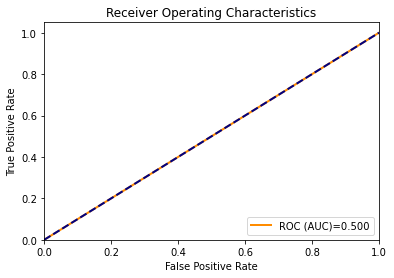

In [15]:
# Generate actuals
act = np.array(data['TARGET_5Yrs'])
# print("Actual proportions: {}".format(get_list_proportions(act)))

bas = np.full(act.shape, mode(act))

# Check performance
pred_scor = save_reg_perf \
    ( targ=act
    , pred=bas
    , pred_prob=bas
    , df_metrics=pred_scor
    , name="Raw baseline"
    , print_matrix=True
    , print_plot=True
    , print_df=False
    )

**Results**
- As expected.
- This is a good start.

## Attempt 1: XGBoost - Default

**Overview**
- Generate and run a stock-standard `XGBClassifier()` model.
- Use only default values.
- Don't do anything fancy.
- Expect to see better performance, but nothing extremely spectacular.

Elapsed time: 0:00:01


pred      
          0     1
targ 0   46   353
     1   72  1929

,name,when,auc,sens,spec,f1
0,Raw baseline,20/Feb 16:11,0.50000,1.00000,0.00000,0.90926
1,01 - XGBoost - Default - out of bag,20/Feb 16:11,0.66738,0.96402,0.11529,0.90077


['./models/Chris/13_XGBoost_Default.joblib']

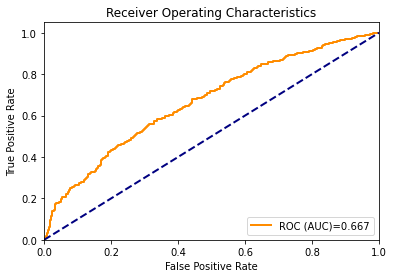

In [16]:
# Import
from xgboost import XGBClassifier

# Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )

# Train
t.tic()
cla.fit(feat_trn, targ_trn, eval_metric="auc")
t.toc()

# Predict
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)

# Check performance
save_reg_perf \
    ( targ=targ_trn
    , pred=pred_trn
    , pred_prob=pred_prob_trn
    , df_metrics=pred_scor
    , name="01 - XGBoost - Default - within bag"
    , print_all=False
    )
save_reg_perf \
    ( targ=targ_val
    , pred=pred_val
    , pred_prob=pred_prob_val
    , df_metrics=pred_scor
    , name="01 - XGBoost - Default - out of bag"
    )

# Backup
dump(cla, "./models/Chris/13_XGBoost_Default.joblib")

**Output**:
- Elapsed time: `0:00:00`
- Final AUC: `0.66738`
- Confusion matrix:<br>
```
    |        | pred      |
    |        | 0  | 1    |
    |targ| 0 | 46 | 353  |
    |    | 1 | 72 | 1929 |
```

**Results**
- As expected; it's better.
- Now let's see if we can tune it to get even better again.

## Attempt 2: XGBoost - Random Search

**Overview**
- As re-defining Random Search processes can be teadious, I've defined a re-usable function that will do all the leg-work for me.
- The anticipated outcome is that it will be better than what is modelled above.

In [17]:
# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=50, high=500)
    , learning_rate=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    , max_depth=randint(low=1, high=200)
    , subsample=uniform(loc=0, scale=1)
    , colsample_bytree=uniform(loc=0, scale=1)
    , gamma=uniform(loc=0, scale=1)
    , reg_alpha=uniform(loc=0, scale=1)
    , reg_lambda=uniform(loc=0, scale=1)
    )

Elapsed time: 0:00:59
Best score: 0.6857233310730229
Best params: {'colsample_bytree': 0.6964691855978616, 'gamma': 0.28613933495037946, 'learning_rate': 1e-05, 'max_depth': 99, 'n_estimators': 280, 'reg_alpha': 0.719150310154773, 'reg_lambda': 0.49111893343259727, 'subsample': 0.7800277619120791}


pred      
          0     1
targ 0   13   386
     1    7  1994

,name,when,auc,sens,spec,f1
0,Raw baseline,20/Feb 16:11,0.50000,1.0000,0.00000,0.90926
1,02 - XGBoost - RandomSearch - within bag,20/Feb 16:12,0.88356,1.0000,0.20923,0.92683
2,02 - XGBoost - RandomSearch - out of bag,20/Feb 16:12,0.69522,0.9965,0.03258,0.91029


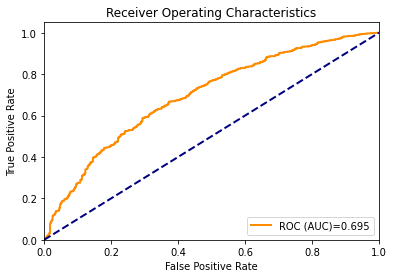

In [18]:
# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Get baseline of full data set
cla, pred_scor = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    , df_metrics=pred_scor
    , n_iter=10
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , dump_name="02 - XGBoost - RandomSearch"
    , print_all=True
    , print_df=True
    )

**Output**:
- Elapsed time: `0:08:49`
- Best score: `0.6934866835784483`
- Final AUC: `0.70406`
- Best params: <br>
`{ 'colsample_bytree': 0.9874783222814236`<br>
`, 'gamma': 0.3494149296248078`<br>
`, 'learning_rate': 0.0001`<br>
`, 'max_depth': 4`<br>
`, 'n_estimators': 149`<br>
`, 'reg_alpha': 0.42834727470094924`<br>
`, 'reg_lambda': 0.2045428595464277`<br>
`, 'subsample': 0.4506364905187348`<br>
`}`
- Confusion matrix:<br>
```
    |        | pred     |
    |        | 0 | 1    |
    |targ| 0 | 4 | 395  |
    |    | 1 | 4 | 1997 |
```

**Results:**
- As expected, the AUC is indeed higher.
- It's interesting that the algorithm chose the hyperparameters that it did. Particularly:
    - `max_depth`: I would have thought that it would have gone deeper than only `4` levels?
    - `n_estimators`: Yes, this number seems about right. However, given the small data set, I would have expected it to go a lot higher though.
    - `learning_rate`: This is a fairly typical learning rate; nothing overly remarkable here.
    - `alpha`, `lambda`, `gamma`: The regularisation is slightly on the lower side of `0.5`, but still quite conservative for the `gamma` and `alpha` parameters; though for `lambda` it has gone quite low to `0.2`. As `alpha` represents `l1` regularisation, it is quite interesting that it would have chosen to increase this value to the extent that it did.
- The model doesn't look like it's overfitting; though I'm still not overly satisfied with the results.
- Further experimentation is needed arount the feature selection aspects.

## Attempt 3: PyTorch Neural Net

**Overview**

We will need to do the following steps:

1. Define custom class for handling Numpy data in to PyTorch Dataset type: `BasketballDataset()`.
1. Define a custom class, inhereted from the `nn.Module` class, that can allow us to manually create the layers & functions we want: `Net()`.
1. Define custom functions for:
    1. Plotting the performance of the Model: `plot_network_training()`.
    1. Training the model: `model_train()`.
    1. Validating the model: `model_validate()`.
    1. Running the overall epochs: `train_overall_network()`.
1. Run the training and review the learning plots.
1. Run the validation data through the network.
1. Validate the model performance.

The layer transformations should be:

- `19`→`20`→`30`→`40`→`20`→`10`→`5`→`1`

**Expected Result**

1. Results will be better than the XGBoost.

In [ ]:
# Imports
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader

# Reproducability
torch.manual_seed(123)

In [100]:
# We need to define a custom Dataset class, so PyTorch can recognise our data... coz it likes to be picky
# Inspired by:
#   https://towardsdatascience.com/deep-learning-for-tabular-data-using-pytorch-1807f2858320
#   https://towardsdatascience.com/better-data-loading-20x-pytorch-speed-up-for-tabular-data-e264b9e34352

# Define
class BasketballDataset(Dataset):
    def __init__(self, feat, targ):
        self.feat = feat.copy().astype(np.float32)
        self.targ = targ.copy().astype(np.float32)
    def __len__(self):
        return len(self.targ)
    def __getitem__(self, index):
        return self.feat[index], self.targ[index]

In [507]:
# Inspiration from:
# https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

# Define net
class Net(nn.Module):
    """Redefine class from torch"""

    # Initalise
    def __init__(self):
        """
        Initialise with all precidences.
        Then manually define layers to be used later
        """
        
        # Imports
        import numpy as np

        # Super initialisation
        super().__init__()

        # Fully connected layers
        # 19→20→30→40→20→10→5→1
        self.fc1 = nn.Linear(19,20)
        self.fc2 = nn.Linear(20,30)
        self.fc3 = nn.Linear(30,40)
        self.fc4 = nn.Linear(40,20)
        self.fc5 = nn.Linear(20,10)
        self.fc6 = nn.Linear(10,5)
        self.fc7 = nn.Linear(5,1)

    # Static propagation 😒
    def old(self, x):
        """Run forward prop"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.sigmoid(self.fc7(x))
        x = x[:,0]
        return x

    # Dynamic propagation 😁
    def forward \
        ( self
        , feat
        , hidden_shapes:list=[20,20,20]
        , hidden_acti:str="relu"
        , final_shape:int=1
        , final_acti:str="sigmoid"
        ):

        # Check
        if type(feat)==np.ndarray:
            feat = torch.from_numpy(feat.astype(np.float32))
        
        # Assertions
        assert np.all([np.isscalar(param) for param in [hidden_acti, final_shape, final_acti]])
        assert isinstance(hidden_shapes, list)
        assert len(hidden_shapes)>0, "Must have at least 1 hidden layer"
        assert np.all([isinstance(elem, int) for elem in hidden_shapes])
        assert isinstance(final_shape, int)
        assert np.all([isinstance(param, str) for param in [hidden_acti, final_acti]])

        # Define number of nodes in input
        input_shape=feat.shape[-1]

        # Work on first hidden layer
        shape = nn.Linear(input_shape, hidden_shapes[0])
        x = shape(feat)
        x = eval("F.{}".format(hidden_acti))(x)

        # Loop other layers
        for layer in range(len(hidden_shapes)-1): #<-- `-1` because skip last layer
            
            # Get shapes
            curr_layer_shape = hidden_shapes[layer]
            next_layer_shape = hidden_shapes[layer+1]
            
            # Work on other hidden layers
            shape = nn.Linear(curr_layer_shape, next_layer_shape)
            x = shape(x)
            x = eval("F.{}".format(hidden_acti))(x)

        # Work on last hidden layer
        shape = nn.Linear(hidden_shapes[-1], final_shape)
        x = shape(x)
        x = eval("F.{}".format(final_acti))(x)

        # Return
        return x

In [508]:
def plot_network_training(metrics:dict):
    
    # Imports
    from IPython.display import clear_output
    import numpy as np
    import matplotlib.pyplot as plt
    from src.utils.misc import all_in

    # Assertions
    assert isinstance(metrics, dict)
    assert all_in(["accu_trn", "loss_trn", "accu_val", "loss_val"], list(metrics.keys()))

    # If only 1 score, then end
    epoch = len(next(iter(metrics.values())))
    if epoch < 2:
        return None

    # Clearn previous output
    clear_output(wait=True)

    # Define space
    N = np.arange(1, len(next(iter(metrics.values())))+1)

    # You can chose the style of your preference
    # print(plt.style.available) to see the available options
    #plt.style.use("seaborn")

    # Plot train loss, train acc, val loss and val acc against epochs passed
    plt.figure(figsize=(8,8))
    
    # Accuracy
    plt.subplot(2,1,1)
    plt.plot(N, metrics.get("accu_trn"), label = "Training Accuracy")
    plt.plot(N, metrics.get("accu_val"), label = "Validation Accuracy")
    plt.legend(loc="best")
    plt.title("Accuracy [Epoch {}]".format(epoch))
    plt.ylim([0,1.1])
    plt.ylabel("Accuracy")
    
    # Loss
    plt.subplot(2,1,2)
    plt.plot(N, metrics.get("loss_trn"), label = "Training Loss")
    plt.plot(N, metrics.get("loss_val"), label = "Validation Loss")
    plt.legend(loc="best")
    plt.title("Loss [Epoch {}]".format(epoch))
    plt.ylabel("Loss")
    plt.xlabel("Epoch #")
    
    # Show
    plt.show()

In [509]:
def model_train \
    ( data_trn:torch.utils.data.Dataset
    , modl:torch.nn.Module
    , crit:torch.nn
    , optm:torch.optim
    , batch_size:int=100
    , hidden_shapes:list=[20,30,40]
    , hidden_acti:str="relu"
    , final_shape:int=1
    , final_acti:str="sigmoid"
    , device:torch.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    , scheduler:bool=True
    ):

    # Set to train
    model.train()
    loss_trn = 0.0
    accu_trn = 0.0

    # Set data generator
    load_trn = DataLoader(data_trn, batch_size=batch_size, shuffle=True, num_workers=0)

    # Loop over each batch
    for batch, data in enumerate(load_trn):
        
        # Extract data
        inputs, labels = data

        # Push data to device
        # inputs, labels = inputs.to(device), labels.to(device)
        inputs.to(device)
        labels.to(device)

        # Zero out the parameter gradients
        optm.zero_grad()

        # Feed forward
        output = modl.forward \
            ( feat=inputs
            , hidden_shapes=hidden_shapes
            , hidden_acti=hidden_acti
            , final_shape=final_shape
            , final_acti=final_acti
            )

        # Calc loss
        loss = crit(output, labels.unsqueeze(1))

        # Global metrics
        loss_trn += loss.item()
        accu_trn += (output.argmax(1) == labels).sum().item()

        # Feed backward
        loss.backward()

        # Optimise
        optm.step()

    # Adjust scheduler
    if scheduler:
        scheduler.step()
    
    return loss_trn/len(data_trn), accu_trn/len(data_trn)

In [510]:
def model_validate \
    ( data_val:torch.utils.data.Dataset
    , modl:torch.nn.Module
    , crit:torch.nn
    , batch_size:int=100
    , hidden_shapes:list=[20,30,40]
    , hidden_acti:str="relu"
    , final_shape:int=1
    , final_acti:str="sigmoid"
    , device:torch.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ):

    # Set to validation
    model.eval()
    accu_val = 0
    loss_val = 0

    # Set generator
    load_val = DataLoader(data_val, batch_size=batch_size, shuffle=True, num_workers=0)

    # Loop over each batch
    for batch, data in enumerate(load_val):
        
        # Extract data
        inputs, labels = data

        # Push data to device
        # inputs, labels = inputs.to(device), labels.to(device)
        inputs.to(device)
        labels.to(device)

        # Don't update gradients
        with torch.no_grad():
            
            # Make predictions
            output = modl \
                ( feat=inputs
                , hidden_shapes=hidden_shapes
                , hidden_acti=hidden_acti
                , final_shape=final_shape
                , final_acti=final_acti
                )

            # Calculate loss
            loss = crit(output, labels.unsqueeze(1))

            # Global metrics
            loss_val += loss.item()
            accu_val += (output.argmax(1) == labels).sum().item()
    
    return loss_val/len(data_val), accu_val/len(data_val)

In [512]:
def train_overall_network \
    ( feat:np.real
    , targ:np.real
    , hidden_shapes:list=[20,20,20]
    , hidden_acti:str="relu"
    , final_shape:int=1
    , final_acti:str="sigmoid"
    , batch_size:int=100
    , epochs:int=500
    , learning_rate:float=0.001
    , device:torch.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    , scheduler:bool=True
    , verbosity:int=10
    , plot_learning:bool=True
    ):

    # Imports
    import numpy as np
    
    # Assertions
    assert np.all([np.all(np.isreal(param)) for param in [feat, targ]])
    assert isinstance(hidden_shapes, list)
    assert len(hidden_shapes)>0, "Must have at least 1 hidden layer"
    assert np.all([isinstance(elem, int) for elem in hidden_shapes])
    assert np.all([np.isscalar(param) for param in [hidden_acti, final_shape, final_acti, batch_size, epochs, learning_rate]])
    assert isinstance(verbosity, (int, type(None)))
    assert np.all([isinstance(param, int) for param in [batch_size, epochs, verbosity]])
    assert np.all([isinstance(param, str) for param in [hidden_acti, final_acti]])
    assert isinstance(learning_rate, float)

    # Initialise data generators
    data_trn = BasketballDataset(feat_trn, targ_trn)
    data_val = BasketballDataset(feat_val, targ_val)
    # load_trn = DataLoader(data_trn, batch_size=batch_size, shuffle=True, num_workers=0)
    # load_val = DataLoader(data_val, batch_size=batch_size, shuffle=True, num_workers=0)

    # Initialise classes
    modl = Net()
    crit = nn.BCELoss()
    optm = optim.Adam(net.parameters(), lr=learning_rate)
    if scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optm)

    # Push network to device
    net.to(device)
    
    # Set dumping ground
    costs = {"epoch": [], "loss_trn": [], "accu_trn": [], "loss_val": [], "accu_val": []}
    loss_trn = 0.0
    accu_trn = 0.0

    # Loop over epochs
    for epoch in range(epochs):

        loss_trn, accu_trn = model_train \
            ( data_trn=data_trn
            , modl=modl
            , crit=crit
            , optm=optm
            , batch_size=batch_size
            , hidden_shapes=hidden_shapes
            , hidden_acti=hidden_acti
            , final_shape=final_shape
            , final_acti=final_acti
            , device=device
            , scheduler=scheduler
            )
        
        loss_val, accu_val = model_validate \
            ( data_val=data_val
            , modl=modl
            , crit=crit
            , batch_size=batch_size
            , hidden_shapes=hidden_shapes
            , hidden_acti=hidden_acti
            , final_shape=final_shape
            , final_acti=final_acti
            , device=device
            )

        # Record progress
        costs["epoch"].append(epoch+1)
        costs["loss_trn"].append(loss_trn)
        costs["accu_trn"].append(accu_trn)
        costs["loss_val"].append(loss_val)
        costs["accu_val"].append(accu_val)

        # Adjust scheduler
        if scheduler:
            scheduler.step()

        # Print stats
        if verbosity:
            if epoch % verbosity == 0 or epoch+1==epochs:
                # Plot learning
                if plot_learning:
                    plot_network_training(costs)
                # Print metrics
                # print("Epoch: {}/{}\tLoss: {:.5f}".format(costs["epoch"][-1], epochs, costs["trn_los"][-1]))

    # Return
    return modl

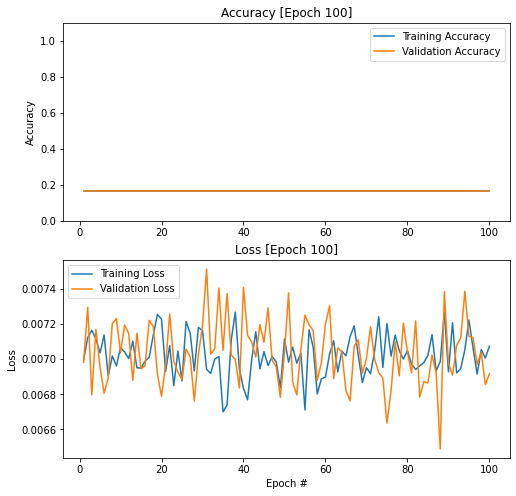

In [513]:
model = train_overall_network \
    ( feat=feat_trn
    , targ=targ_trn
    , hidden_shapes=[20,30,40,20,10,5]
    , hidden_acti="relu"
    , final_shape=1
    , final_acti="sigmoid"
    , batch_size=100
    , epochs=100
    , learning_rate=0.00001
    , verbosity=10
    , scheduler=False
    )

**Results**

1. This is a shocking, _shocking_ learning rate.
1. It seems almost random.
1. It seems like the network is not learning from it's previous itterations, and as though the optimiser is not actually upgrading or imporving upon itsown performance.
1. This is definitely not production ready.

pred   
           0  1
targ 0   399  0
     1  1994  7

,name,when,auc,sens,spec,f1
0,Raw baseline,20/Feb 16:11,0.50000,1.0000,0.00000,0.90926
1,02 - XGBoost - RandomSearch - within bag,20/Feb 16:12,0.88356,1.0000,0.20923,0.92683
2,02 - XGBoost - RandomSearch - out of bag,20/Feb 16:12,0.69522,0.9965,0.03258,0.91029
3,03 - PyTorch - SixLayerModule,21/Feb 14:08,0.68296,0.0035,1.00000,0.00697


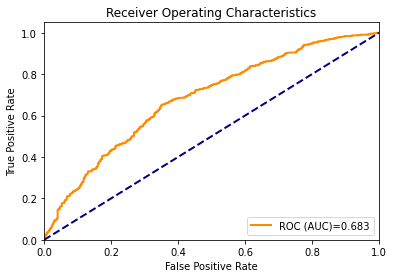

In [651]:
model.eval()
torch.manual_seed(499607495906900)
pred_prob = model(feat_val).squeeze(1).detach().numpy()
pred = pred_prob.round()
pred_scor = save_reg_perf \
    ( targ=targ_val
    , pred=pred
    , pred_prob=pred_prob
    , df_metrics=pred_scor
    , name="03 - PyTorch - SixLayerModule"
    )

**Performance**
- Even so, it seems like it is able to perfrm quite well on the validation data.
- Albeit, the `auc` score seems decent enough... Being at `0.68296`.
- However, look at the False Positives from the Confusion Matrix.
- As a result, the `sens`, `spec` and `f1` scores are totally out of whack...
- It's basically just guessed that all of the values are `0` (except for 7 scores which is guessed as `1`).
- In my opinion, this model is no better than random guessing.

## Final Decision

**Overview:**
- It is decided to re-run the model *with* the percentages.
- This one will be dumped and also submitted to Kaggle.

# Examine Model

**Overview**
- Let's take a look at the different parts of the model.
- Mostly interested in the visualisation of the Feature Importances

# Final Processing & Submitting

## Define final processing steps

In [27]:
def final_prediction_processing \
    ( final_model_path:str
    , data_scaler_path:str
    , test_data_path:str="./data/raw/test.csv"
    , test_col_indices=None
    , submission_data_path:str="./data/external/final.csv"
    , check:bool=False
    ):
    """
    Process the data for the final prediction.
    Note, this will update the prediction and save it to the `submission_data_path` location.

    Args:
        final_model_path (str): The location from which the final model should be drawn from. Note, this model should be saved as a `` file type, and once imported, should be a sklearn model class.
        data_scaler_path (str): The location from which the data scaler should be imported from. Note, this should be a sklearn preprocessing class
        test_data_path (str, optional): The location from which the test data should be imported. Note, it should be a `.csv` file type. Defaults to "./data/raw/test.csv".
        submission_data_path (str, optional): The location to which the final submission data should be stored. Note, it should be a `.csv` file type. Defaults to "./data/external/final.csv".
        check (bool, optional): Optional flag for wheather or not to `display()` the final data frame, mainly for checking purposes. Defaults to False.

    Returns:
        pd.DataFrame: The updated `submission_data` dataframe
    """

    # Imports
    import numpy as np
    import pandas as pd
    from src.utils.misc import str_right

    # Assertions
    for parameter in [final_model_path, data_scaler_path, test_data_path, submission_data_path]:
        assert np.isscalar(parameter)
        assert isinstance(parameter, str)
        if parameter in [final_model_path, data_scaler_path]:
            assert str_right(parameter, 7) == ".joblib"
        if parameter in [test_data_path, submission_data_path]:
            assert str_right(parameter, 4) == ".csv"
    assert isinstance(check, bool)
    assert isinstance(test_col_indices, (type(None), list))
    if isinstance(test_col_indices, list):
        assert np.all([isinstance(i, int) for i in test_col_indices])
    
    # Import selected data
    final_model = load(final_model_path)
    data_scaler = load(data_scaler_path)
    test_data = pd.read_csv(test_data_path)

    # Process final data
    submission_data = test_data.pop('Id')
    test_data = test_data.drop(['Id_old'], axis=1)
    test_data = data_scaler.fit_transform(test_data)
    if not test_col_indices is None:
        test_data = test_data[:, test_col_indices]

    # Get prediction
    final_prediction = final_model.predict_proba(test_data)

    # Form final data
    submission_data = pd.concat([pd.DataFrame(submission_data), pd.DataFrame(final_prediction[:,1])], axis=1)
    submission_data.columns = ["Id", "TARGET_5Yrs"]
    # submission_data["TARGET_5Yrs"] = submission_data["TARGET_5Yrs"].apply(lambda pred: 1 if pred > 0.5 else 0)

    # Check
    if check:
        display(submission_data)

    # Save to file
    submission_data.to_csv(submission_data_path, index=False)

    return submission_data

In [28]:
# Process the final data
submission_data = final_prediction_processing \
    ( final_model_path = "./models/Chris/15_XGBoost_RandomSearch_FeatureSelection.joblib"
    , data_scaler_path = "./models/Chris/scaler.joblib"
    , test_data_path = "./data/raw/test.csv"
    , test_col_indices = pcts
    , submission_data_path = "./data/external/final.csv"
    , check = True
    )

,Id,TARGET_5Yrs
0,0,0.504316
1,1,0.504441
2,2,0.506493
3,3,0.506498
4,4,0.504183
...,...,...
3794,3794,0.506547
3795,3795,0.504704
3796,3796,0.503785
3797,3797,0.506516


## Submit to Kaggle

In [29]:
# Function to call Kaggle API
def call_kaggle_api(upload_file, upload_message):
    """
    Call the Kaggle API to submit a file
    Inspiration: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script#answer-579917
    
    Args:
        upload_file (str): The source path where the file will be uploaded _from_.
        upload_message (str): The message that will be sent to Kaggle for this submission.

    Raises:
        Exception: CallProcessError, incase subprocess has a wobbly
        Exception: Exception, for everything else

    Returns:
        str: The confirmation string from the API call
    """

    import subprocess

    bash_call = "kaggle competitions submit --competition uts-advdsi-nba-career-prediction --file {upload_file} --message {upload_message} --quiet".format(upload_file=upload_file, upload_message=upload_message)

    try:        
        result = subprocess.run(bash_call, check=True, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as err:
        raise Exception(str(err.stderr.decode("utf-8")))
    except Exception as err:
        raise Exception(err)
    else:
        return result.stdout.decode("utf-8")

In [30]:
# Call the API
if False:
    call_kaggle_api \
        ( upload_file = "./data/external/final.csv"
        , upload_message = "CtrlAltElite_XGBoost_RandomSearch_FeatureSelection"
        )